<a href="https://colab.research.google.com/github/jeyakumar-nanc/MachineLearning/blob/main/CVSS%20Score%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


**CS675 - Milestone 4 Experiments**

Group Members:

*   Jordan Harilal
*   Nancy Jeyakumar
*   Prasuna Kumari Pothabolu





---



# CVSS Score Prediction using  NLP

## Introduction

**What is CVE & CVSS score?**

Common Vulnerabilities and Exposures (CVE) is a list of computer security threats provided by the U.S. Department of Homeland Security and maintained by the MITRE corporation to identify and categorize vulnerabilities in software and firmware.
CVE provides a free dictionary for organizations to improve their cyber security. A CVE entry describes a known vulnerability or exposure. Each CVE entry contains a standard identifier number with status indicator, a brief description and references related vulnerability reports and advisories.
CVSS scores are commonly used by infosec teams as part of a vulnerability management program to provide a point of comparison between vulnerabilities, and to prioritize remediation of vulnerabilities. 


**CVSS Score Prediction - Approach by others**

We reviewed exploratory data analysis approaches by various folks on how to work on this dataset. Laura's work with CVE data set stood out to me among others. She had done thorough analysis on this dataset and performed various studies like CVSS score prediction, time series analysis and topic modelling. 

**For CVSS score prediction** - The goal of this study is predicting the CVSS base scores based on vulnerability description using text mining. Describing the vulnerabilities to natural language is easier than to find and compute CVSS base score parameters


Link to CVSS score prediction - https://github.com/lauravoicu/Common-Vulnerabilities-Exposures/blob/main/Text-Mining-Prediction.ipynb

She had various algorithms we learnt in class like Decision Tree, Random Forest, KNeighbours , Gradient boost and AdaBoost. Among these algorithms Random Forest. Random forest gave the highest accuracy. The thing that stood out the most is the various techniques used to visualize the data, handling imbalances in the dataset and how to discretize a continuous variable to use in classification problem and choosing the optimal hyperparameters for the classifier. 

The maximum accuracy that the author was able to achieve was around 68% for Random forest classifier. This notebook demonstrates the experiments we tried with this dataset by doing datacleanup, feature engineering and also tried to implement PCA , SVM to see how the accuracy is with those models.



---

## Data Preparation

For most of the data prep, we decided to have very similar preproessing steps but made a significant change in terms of the resulting labels. The data presents a cvss score that is a single decimal float, and the author decided to round all values down using np.floor. We decided to round to the closest
integer. 

### Cleaning up attributes


Much like the original paper, we're going to focus on the NLP aspect and trying to identify the security and threat level based on the name of the ticket, along with the description and summary of the ticket

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict

In [ ]:
# from google.colab import files

# files.upload()

In [ ]:
raw_df = pd.read_csv('cve.csv')

In [ ]:
raw_df.head()

,Unnamed: 0,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity
0,CVE-2019-16548,2019-11-21 15:15:00,2019-11-21 15:15:00,6.8,352,Cross-Site Request Forgery (CSRF),A cross-site request forgery vulnerability in ...,NaN,NaN,NaN,NaN,NaN,NaN
1,CVE-2019-16547,2019-11-21 15:15:00,2019-11-21 15:15:00,4.0,732,Incorrect Permission Assignment for Critical ...,Missing permission checks in various API endpo...,NaN,NaN,NaN,NaN,NaN,NaN
2,CVE-2019-16546,2019-11-21 15:15:00,2019-11-21 15:15:00,4.3,639,Authorization Bypass Through User-Controlled Key,Jenkins Google Compute Engine Plugin 4.1.1 and...,NaN,NaN,NaN,NaN,NaN,NaN
3,CVE-2013-2092,2019-11-20 21:22:00,2019-11-20 21:15:00,4.3,79,Improper Neutralization of Input During Web P...,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,NaN,NaN,NaN,NaN,NaN,NaN
4,CVE-2013-2091,2019-11-20 20:15:00,2019-11-20 20:15:00,7.5,89,Improper Neutralization of Special Elements u...,SQL injection vulnerability in Dolibarr ERP/CR...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
col = list(raw_df.columns)

In [ ]:
col

['Unnamed: 0',
 'mod_date',
 'pub_date',
 'cvss',
 'cwe_code',
 'cwe_name',
 'summary',
 'access_authentication',
 'access_complexity',
 'access_vector',
 'impact_availability',
 'impact_confidentiality',
 'impact_integrity']

In [ ]:
col.remove('Unnamed: 0')
col.remove('cvss')
col.remove('cwe_code')
col.remove('summary')

In [ ]:
col

['mod_date',
 'pub_date',
 'cwe_name',
 'access_authentication',
 'access_complexity',
 'access_vector',
 'impact_availability',
 'impact_confidentiality',
 'impact_integrity']

In [ ]:
raw_df = raw_df.drop(col, axis=1)

In [ ]:
raw_df.rename({'Unamed: 0': 'id'}, axis=1, inplace=True)

In [ ]:
clean_df = raw_df.copy()

In [ ]:
clean_df = clean_df.rename({'Unnamed: 0': 'id'}, axis=1)

In [ ]:
clean_df

,id,cvss,cwe_code,summary
0,CVE-2019-16548,6.8,352,A cross-site request forgery vulnerability in ...
1,CVE-2019-16547,4.0,732,Missing permission checks in various API endpo...
2,CVE-2019-16546,4.3,639,Jenkins Google Compute Engine Plugin 4.1.1 and...
3,CVE-2013-2092,4.3,79,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...
4,CVE-2013-2091,7.5,89,SQL injection vulnerability in Dolibarr ERP/CR...
...,...,...,...,...
89655,CVE-2007-6444,5.0,20,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...
89656,CVE-2007-6443,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...
89657,CVE-2007-6442,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...
89658,CVE-2007-6370,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...


In [ ]:
clean_df = clean_df.drop('id', axis=1)

In [ ]:
# Cleaned data only containing the cvss, cwe code, and summary. No need to 
# include the name of the code, since it's redundant to the cwe_code
clean_df.head()

,cvss,cwe_code,summary
0,6.8,352,A cross-site request forgery vulnerability in ...
1,4.0,732,Missing permission checks in various API endpo...
2,4.3,639,Jenkins Google Compute Engine Plugin 4.1.1 and...
3,4.3,79,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...
4,7.5,89,SQL injection vulnerability in Dolibarr ERP/CR...


### Tokenizing words and Cleaning Text

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_df['summary']

0        A cross-site request forgery vulnerability in ...
1        Missing permission checks in various API endpo...
2        Jenkins Google Compute Engine Plugin 4.1.1 and...
3        Cross-site Scripting (XSS) in Dolibarr ERP/CRM...
4        SQL injection vulnerability in Dolibarr ERP/CR...
                               ...                        
89655    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
89656    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
89657    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
89658    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
89659    ** REJECT **  DO NOT USE THIS CANDIDATE NUMBER...
Name: summary, Length: 89660, dtype: object

In [ ]:
# Creating an extra copy of the summary to process and compare to
# the original
clean_df['summary_processed'] = clean_df['summary']

In [ ]:
# Removing stopwords
clean_df['summary_processed'] = clean_df.summary_processed.apply(lambda x: ' '.join([word for word in x.split() if (word not in stop_words)]))

In [ ]:
# Removing digits
clean_df['summary_processed'] = clean_df.summary_processed.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))

In [ ]:
# Removing Punctuation

translator = re.compile('[%s]' % re.escape(string.punctuation))

clean_df['summary_processed'] = clean_df.summary_processed.apply(lambda x: translator.sub(' ', x))

In [ ]:
# Removing single letters
clean_df['summary_processed'] = clean_df.summary_processed.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [ ]:
# Final check to ensure that each summary line has values

clean_df.shape

(89660, 4)

In [ ]:
# This shows that there are no values that were dropped
clean_df.dropna(how='any', axis=0).shape

(89660, 4)

In [ ]:
# Changing all letters to lowercase for consistency

clean_df['summary_processed'] = clean_df.summary_processed.str.lower()

In [ ]:
clean_df.head()

,cvss,cwe_code,summary,summary_processed
0,6.8,352,A cross-site request forgery vulnerability in ...,cross site request forgery vulnerability jenki...
1,4.0,732,Missing permission checks in various API endpo...,missing permission checks various api endpoint...
2,4.3,639,Jenkins Google Compute Engine Plugin 4.1.1 and...,jenkins google compute engine plugin earlier v...
3,4.3,79,Cross-site Scripting (XSS) in Dolibarr ERP/CRM...,cross site scripting xss dolibarr erp crm allo...
4,7.5,89,SQL injection vulnerability in Dolibarr ERP/CR...,sql injection vulnerability dolibarr erp crm a...


### Label Preparation

A small change that we will do when it comes to labels, is that instead of
Using np.floor, which rounds down to the nearest integer, we will use the round Function to result in the closest integer. This means that for the value, 5,
instead of representing cvss scores from [5.0, 5.9], it will be scores between
[4.6, 5.5] to minimize the distance between the single decimal label and the
corresponding integer. One reason why this may be controversial is that each 
range could represent a certain meaning. For example, 4-4.9 could mean that the request is urgent, and 5-5.9 could be a critical request. However, we are making the assumption that there are no breakoff points that have distinct meanings outside of the scale

round() is slightly inefficient when it comes to processing ties, and will round to even. I created a function to be more accurate.

In [ ]:
def cvss_round(x):
  remainder = x - np.floor(x)
  if remainder <= 0.4:
    return np.floor(x)
  else:
    return np.ceil(x)

In [ ]:
clean_df['cvss_rounded'] = clean_df.cvss.apply(lambda x: cvss_round(x))

In [ ]:
clean_df.tail()

,cvss,cwe_code,summary,summary_processed,cvss_rounded
89655,5.0,20,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,reject do not use this candidate number consul...,5.0
89656,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,reject do not use this candidate number consul...,5.0
89657,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,reject do not use this candidate number consul...,5.0
89658,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,reject do not use this candidate number consul...,5.0
89659,5.0,119,** REJECT ** DO NOT USE THIS CANDIDATE NUMBER...,reject do not use this candidate number consul...,5.0


In [ ]:
work_df = clean_df[['cvss_rounded', 'summary_processed']]

In [ ]:
work_df

,cvss_rounded,summary_processed
0,7.0,cross site request forgery vulnerability jenki...
1,4.0,missing permission checks various api endpoint...
2,4.0,jenkins google compute engine plugin earlier v...
3,4.0,cross site scripting xss dolibarr erp crm allo...
4,8.0,sql injection vulnerability dolibarr erp crm a...
...,...,...
89655,5.0,reject do not use this candidate number consul...
89656,5.0,reject do not use this candidate number consul...
89657,5.0,reject do not use this candidate number consul...
89658,5.0,reject do not use this candidate number consul...


In [ ]:
# Reseting Axis and preparing working df for training and testing
# work_df = work_df.drop('id', axis=1)
work_df = work_df.rename(columns={'cvss_rounded': 'cvss', 'summary_processed': 'summary'})

In [ ]:
# Checking unique values for cvss to ensure proper labels
work_df.cvss = work_df.cvss.apply(lambda x: int(x))
work_df.cvss.unique()

array([ 7,  4,  8,  5,  2, 10,  9,  6,  3,  1,  0])

In [ ]:
# Final, processed df ready for training / testing
work_df.head()

,cvss,summary
0,7,cross site request forgery vulnerability jenki...
1,4,missing permission checks various api endpoint...
2,4,jenkins google compute engine plugin earlier v...
3,4,cross site scripting xss dolibarr erp crm allo...
4,8,sql injection vulnerability dolibarr erp crm a...


### Quick EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

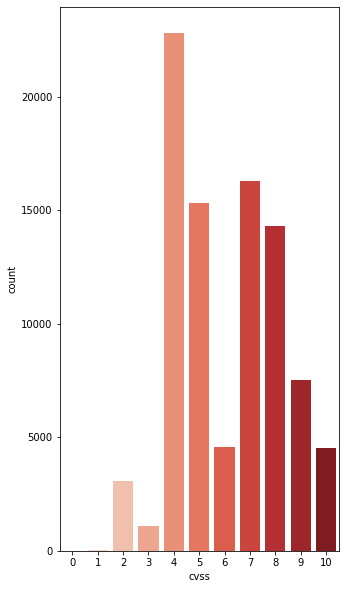

In [ ]:
# Viewing distribution of values

f, ax = plt.subplots(figsize=(5, 10))
sns.countplot(x='cvss', data=work_df, palette='Reds')

Most of the vulnerabilities are scored as 4,5,6 or 7. Since the other classes weren’t well represented, using micro average F1 score metrics to evaluate the performance of the algorithms.

In comparison to the original, there are significantly less datapoints for 6, and significantly more values for 8. Also, there appears to be no datapoints that represent the '1' label, which could be a weakness in the way we processed this data, but it is in exchange for a stronger understanding of the mid-high range datapoints between 4-9.

In this case, we can expect to have low accuracy for the 1 prediciton, Since there are very few datapoints at 1. We will remove these points, since at this scale, it is unlikely for the model to learn the features of this class well. It's only a loss of 13 data points which we can afford.

In [ ]:
work_df['cvss'].value_counts()

4     22803
7     16306
5     15336
8     14324
9      7536
6      4579
10     4545
2      3091
3      1093
1        46
0         1
Name: cvss, dtype: int64

In [ ]:
work_df = work_df[work_df['cvss'] != 1]

In [ ]:
work_df['cvss'].value_counts()

4     22803
7     16306
5     15336
8     14324
9      7536
6      4579
10     4545
2      3091
3      1093
0         1
Name: cvss, dtype: int64

In [ ]:
# this would not let us stratify on cvss later on and have an equal distribution of class in the train-test-split
work_df = work_df[(work_df["cvss"]>0)]

In [ ]:
cumulative_sum = {}

for x in work_df["summary"].values:
    cumulative_sum.update(dict.fromkeys(set(x.lower().split())))

print(len(cumulative_sum))

67744




---


## Feature Engineering


---





In [ ]:
texts = work_df['summary'].astype('str')
labels = work_df['cvss']

wpt = nltk.WordPunctTokenizer()
tokenized_texts = [wpt.tokenize(text) for text in texts]

In [ ]:
# keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1

x_train, x_test, y_train, y_test = train_test_split(tokenized_texts, labels,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels,
                                                  random_state = RANDOM_STATE)

In [ ]:
np.save("train_dataset_features.npy", np.array(x_train))
np.save("train_dataset_labels.npy", np.array(y_train))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
np.save("test_dataset_features.npy", np.array(x_test))
np.save("test_dataset_labels.npy", np.array(y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, 
                        min_df = 5, max_df = 0.8) 
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_tfidf = tfidf_vectorizer.transform(x_test)

x_train_tfidf.shape

(80651, 12260)

In [ ]:
# return a list of (term, score/frequency) pairs for each distinct term 
scores = np.asarray(x_train_tfidf.mean(axis = 0)).ravel().tolist()
scores_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'tfidf': scores})
df_tfidf = scores_df.sort_values(by = 'tfidf', ascending = False).head(50)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_tfidf

,word,tfidf
11396,via,0.036645
353,allows,0.036114
8806,remote,0.035875
716,attackers,0.034228
11571,vulnerability,0.033932
548,arbitrary,0.030988
7795,php,0.027512
2343,cve,0.023810
3505,execute,0.022818
10590,the,0.022779


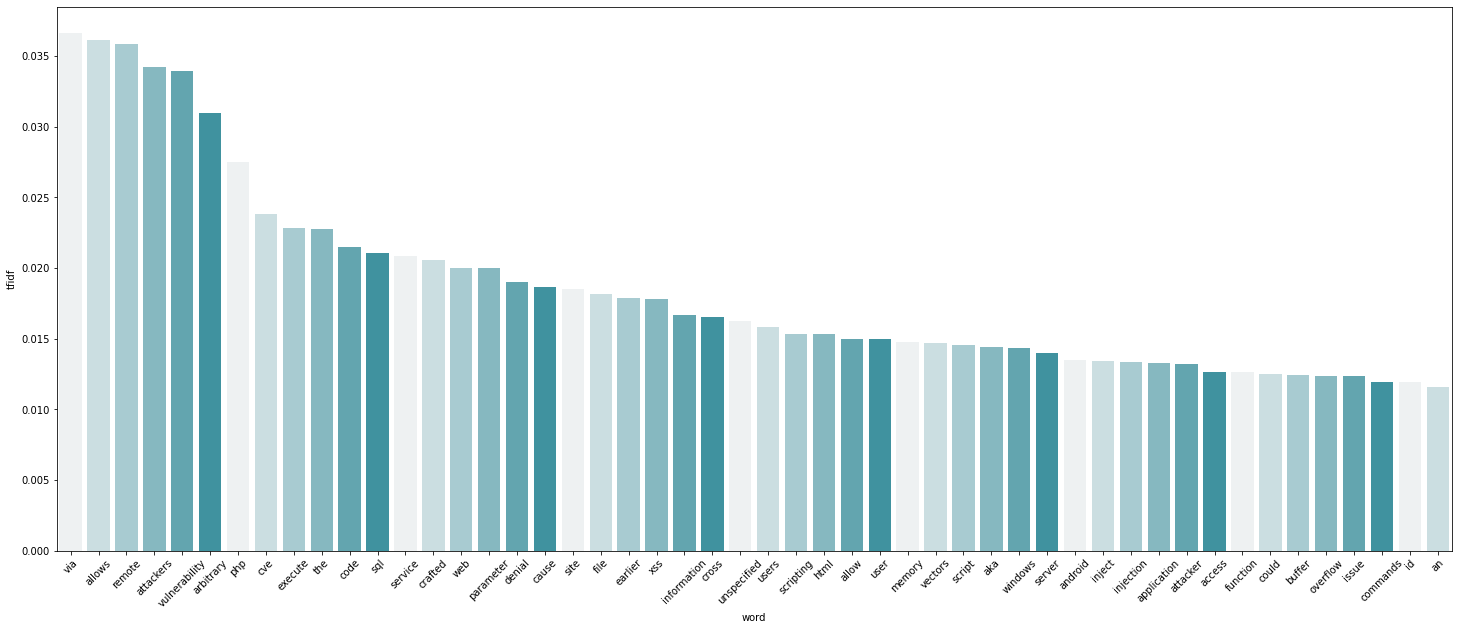

In [ ]:
plt.figure(figsize = (25,10))
sns.barplot(x = 'word', y = 'tfidf', data = df_tfidf, palette = sns.light_palette((210, 90, 60), input = "husl"))
plt.xticks(rotation = 45)
plt.show()

In [ ]:
np.save("train_dataset_tfidf_features.npy", np.array(x_train_tfidf))
np.save("train_dataset_tfidf_labels.npy", np.array(y_train))

np.save("test_dataset_tfidf_features.npy", np.array(x_test_tfidf))
np.save("test_dataset_tfidf_labels.npy", np.array(y_test))

<80651x12260 sparse matrix of type '<class 'numpy.float64'>'
	with 1895341 stored elements in Compressed Sparse Row format>


Text(0.5, 1.0, 'Sparse Matrix 100 Sample')

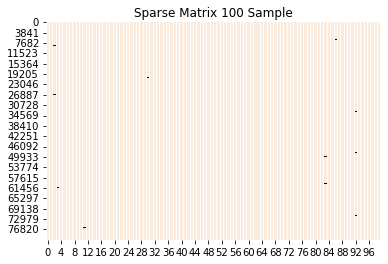

In [ ]:
print(repr(x_train_tfidf))

sns.heatmap(x_train_tfidf.todense()
            [:,np.random.randint(0, x_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix 100 Sample')



---

## Model Building

---



In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, accuracy_score
from sklearn.decomposition import PCA

In [ ]:
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

In [ ]:
def check_model_and_test(x_train, y_train, x_test, y_test, classifiers):
    for model in classifiers:
        this_model = model.__class__.__name__ #get the name of the classifier
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        print(f'{this_model} f1 score:')
        score = f1_score(y_test, y_pred, average='micro')
        print(f'{score:.4f}')
        print('\n')

In [ ]:
check_model_and_test(x_train_tfidf, y_train, x_test_tfidf, y_test, classifiers)

KNeighborsClassifier f1 score:
0.5929


DecisionTreeClassifier f1 score:
0.6362


RandomForestClassifier f1 score:
0.7043


AdaBoostClassifier f1 score:
0.5296


GradientBoostingClassifier f1 score:
0.6449




---

## Tuning Models HyperParameters

---

Below common method TuneClassfier is defined to tune the classifier for given hyperparameters with different values.

Grid is parameter is to hold hyperparameters with values.

In [ ]:
#Tune classifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
def TuneClassifier(model,grid,X_train,y_train):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
  print("model fitting started")
  grid_result = grid_search.fit(X_train,y_train)
  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#tuning Knn_classfifier
model = KNeighborsClassifier()
n_neighbors = range(1, 11, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
Kngrid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
#TuneClassifier(model,Kngrid,x_train_tfidf, y_train)

**Knn_classifier:**

Classifier implementing the k-nearest neighbors vote.

Hyper Parameters:

**n_neighbors : (1,5,7,9,11) used

Number of neighbors to use by default(5) for kneighbors queries.

weights : {‘uniform’, ‘distance’}

Weight function used in prediction.

uniform : uniform weights. All points in each neighborhood are weighted equally.

distance : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

In [ ]:
#tuning Decission tree classfifier
DSmodel = DecisionTreeClassifier()
max_depth=[10,50,100]
min_samples_leaf=[20,50,60]
min_samples_split=[2,5,10]

# define grid search
DSgrid = dict(max_depth=max_depth,min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)
#TuneClassifier(DSmodel,DSgrid,x_train_tfidf, y_train)

**DecisionTreeClassifier:**

HyperParameters:

**max_depth :**int, default=None
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_split:** int or float, default=2
The minimum number of samples required to split an internal node:

If int, then consider min_samples_split as the minimum number.

If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

**min_samples_leaf :**int or float, default=1
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

If int, then consider min_samples_leaf as the minimum number.

If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

**Randomforest classifier performed the best here, we're going to explore further with it**

In [ ]:
n_est = [50, 100, 200]
max_d = [1, 10, 25, None]

In [ ]:
best_acc = 0
best_param = (0, 0)

for val in n_est:
  for depth in max_d:
    rf = RandomForestClassifier(verbose=1 ,n_estimators=val, max_depth=depth)
    print('_'*80)
    rf.fit(x_train_tfidf, y_train)
    print()
    print('Params: {} estimators, {} depth'.format(val, depth))
    curr_acc = accuracy_score(y_test, rf.predict(x_test_tfidf))
    print(curr_acc)
    print()
    if curr_acc > best_acc:
      best_acc = curr_acc
      best_params = (val, depth)
      print('***Updated Best***')
      print()
    print('_'*80)


________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 50 estimators, 1 depth
0.25440749832626647

***Updated Best***

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 50 estimators, 10 depth
0.49185449676411513

***Updated Best***

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished



Params: 50 estimators, 25 depth
0.6304396340102656

***Updated Best***

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 50 estimators, None depth


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6985047980361526

***Updated Best***

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished



Params: 100 estimators, 1 depth
0.25440749832626647

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished



Params: 100 estimators, 10 depth
0.5058022762776166

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   33.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 100 estimators, 25 depth


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6376924793572863

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 100 estimators, None depth


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


0.7033028341887971

***Updated Best***

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 200 estimators, 1 depth


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.25440749832626647

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 200 estimators, 10 depth


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4867217139031466

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 200 estimators, 25 depth


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.644275831287659

________________________________________________________________________________
________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  9.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Params: 200 estimators, None depth
0.7083240348136577

***Updated Best***

________________________________________________________________________________


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished


**We were able to squeeze another 0.6 % accuracy on top of the base model with these params. Coincidentally, these are the default parameters for the  Random Forest objest**

In [ ]:
print(best_acc)
print(best_params)

0.7083240348136577
(200, None)


In [ ]:
#New train test split size

x_train, x_test, y_train, y_test = train_test_split(tokenized_texts, labels,
                                                  test_size = 0.2, stratify = labels,
                                                  random_state = RANDOM_STATE)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, 
                        min_df = 5, max_df = 0.8) 
x_train_tf2 = tfidf_vectorizer.fit_transform(x_train) 
x_test_tf2 = tfidf_vectorizer.transform(x_test)

x_train_tf2.shape

(71690, 11427)

In [ ]:
rf_final = RandomForestClassifier(n_estimators=100, max_depth=None)

In [ ]:
rf_final.fit(x_train_tf2, y_train)

RandomForestClassifier()

In [ ]:
training_acc = accuracy_score(y_train, rf_final.predict(x_train_tf2)) 
test_acc = accuracy_score(y_test, rf_final.predict(x_test_tf2))
print('Training Accuracy: {}'.format(training_acc))
print('Test Accuracy: {}'.format(test_acc))

Training Accuracy: 0.9926907518482354
Test Accuracy: 0.6960888244155554


In [ ]:
classes = np.array([2, 3, 4, 7, 6, 5, 8, 9, 10])

In [ ]:
train_con = confusion_matrix(y_train, rf_final.predict(x_train_tf2), labels=classes) 
test_con = confusion_matrix(y_test, rf_final.predict(x_test_tf2), labels=classes)

In [ ]:
work_df['cvss'].value_counts()*0.8

4     18242.4
7     13044.8
5     12268.8
8     11459.2
9      6028.8
6      3663.2
10     3636.0
2      2472.8
3       874.4
Name: cvss, dtype: float64

In [ ]:
print(np.sum(train_con, axis=1))

[ 2473   874 18242 13045  3663 12269 11459  6029  3636]


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_con,
                              display_labels=classes)

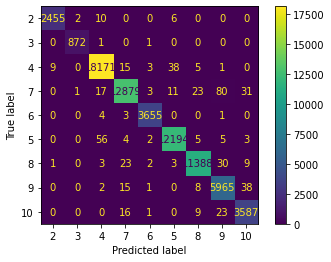

In [ ]:
disp.plot()
plt.show()

In [ ]:
disp2 = ConfusionMatrixDisplay(confusion_matrix=test_con,
                              display_labels=classes)

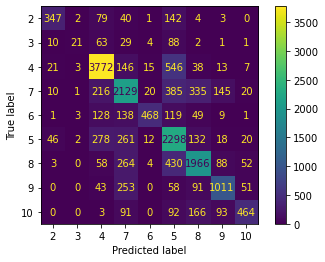

In [ ]:
disp2.plot()
plt.show()

In [ ]:
print(classification_report(y_train, rf_final.predict(x_train_tf2), labels=classes))

              precision    recall  f1-score   support

           2       1.00      0.99      0.99      2473
           3       1.00      1.00      1.00       874
           4       0.99      1.00      1.00     18242
           7       0.99      0.99      0.99     13045
           6       1.00      1.00      1.00      3663
           5       1.00      0.99      0.99     12269
           8       1.00      0.99      0.99     11459
           9       0.98      0.99      0.98      6029
          10       0.98      0.99      0.98      3636

    accuracy                           0.99     71690
   macro avg       0.99      0.99      0.99     71690
weighted avg       0.99      0.99      0.99     71690



In [ ]:
print(classification_report(y_test, rf_final.predict(x_test_tf2), labels=classes))

              precision    recall  f1-score   support

           2       0.79      0.56      0.66       618
           3       0.66      0.10      0.17       219
           4       0.81      0.83      0.82      4561
           7       0.64      0.65      0.64      3261
           6       0.89      0.51      0.65       916
           5       0.55      0.75      0.64      3067
           8       0.71      0.69      0.70      2865
           9       0.73      0.67      0.70      1507
          10       0.75      0.51      0.61       909

    accuracy                           0.70     17923
   macro avg       0.73      0.58      0.62     17923
weighted avg       0.71      0.70      0.69     17923



---

### Modelling with KNN and Decission Classifiers (tuned hyperParameters)

---

In [ ]:
classifiers1 = [
        KNeighborsClassifier(n_neighbors=7,weights='distance',metric='manhattan'),
        DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=20,   random_state=42)
    ]

In [ ]:
check_model_and_test(x_train_tfidf, y_train, x_test_tfidf, y_test, classifiers1)

KNeighborsClassifier f1 score:
0.6338


DecisionTreeClassifier f1 score:
0.6420






---

### Experiment with SVM

---



We also want to try experimenting with SVM for this code, however, the time it takes to train is incredibly long andnot practical. Therefore, we will take a much small sample from the dataset and use that.

In [ ]:
x_train_tf2.shape

(71690, 11427)

In [ ]:
x_test_tf2.shape

(17923, 11427)

In [ ]:
x_train_svm = x_train_tf2[:15000]
y_train_svm = y_train[:15000]
x_test_svm = x_test_tf2[:3000]
y_test_svm = y_test[:3000]

In [ ]:
svm = SVC(C=10, kernel='linear', verbose=1)

In [ ]:
svm.fit(x_train_svm, y_train_svm)

[LibSVM]

SVC(C=10, kernel='linear', verbose=1)

In [ ]:
pred_svm_train = svm.predict(x_train_svm)
pred_svm_test = svm.predict(x_test_svm)

In [ ]:
classes = []
for i in range(2,11):
  classes.append(i)

In [ ]:
classes

array([ 2,  3,  4,  7,  6,  5,  8,  9, 10])

In [ ]:
training_acc = accuracy_score(y_train_svm, pred_svm_train)
test_acc = accuracy_score(y_test_svm, pred_svm_test)

print('training accuracy: {}'.format(training_acc))
print('test accuracy: {}'.format(test_acc))

svm_con_train = confusion_matrix(y_train_svm, pred_svm_train, labels=classes)
svm_con_test = confusion_matrix(y_test_svm, pred_svm_test, labels=classes)

training accuracy: 0.9696
test accuracy: 0.612


In [ ]:
work_df['cvss'].value_counts()

4     22803
7     16306
5     15336
8     14324
9      7536
6      4579
10     4545
2      3091
3      1093
Name: cvss, dtype: int64

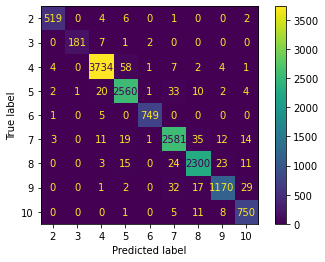

In [ ]:
disp = ConfusionMatrixDisplay(svm_con_train, display_labels=classes)
disp.plot()
plt.show()

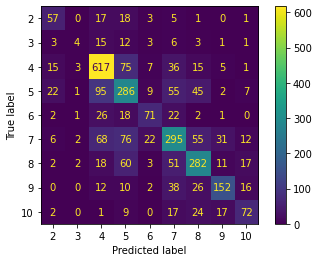

In [ ]:
disp = ConfusionMatrixDisplay(svm_con_test, display_labels=classes)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train_svm, pred_svm_train))

              precision    recall  f1-score   support

           2       0.98      0.98      0.98       532
           3       0.99      0.95      0.97       191
           4       0.99      0.98      0.98      3811
           5       0.96      0.97      0.97      2633
           6       0.99      0.99      0.99       755
           7       0.96      0.96      0.96      2676
           8       0.97      0.97      0.97      2376
           9       0.96      0.94      0.95      1251
          10       0.92      0.97      0.95       775

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



In [ ]:
print(classification_report(y_test_svm, pred_svm_test))

              precision    recall  f1-score   support

           2       0.52      0.56      0.54       102
           3       0.31      0.08      0.13        48
           4       0.71      0.80      0.75       774
           5       0.51      0.55      0.53       522
           6       0.59      0.50      0.54       143
           7       0.56      0.52      0.54       567
           8       0.62      0.63      0.63       446
           9       0.69      0.59      0.64       256
          10       0.57      0.51      0.54       142

    accuracy                           0.61      3000
   macro avg       0.56      0.53      0.54      3000
weighted avg       0.61      0.61      0.61      3000






---
###Experiment with Dimensionality Reduction

---









We also want to try experimenting with PCA for this code, however, the time it takes to train is incredibly long and not practical. Therefore, we will take a much small sample from the dataset and use that.

In [ ]:
from sklearn.decomposition import PCA

x_train_pca = x_train_tf2[:15000]
y_train_pca = y_train[:15000]
x_test_pca = x_test_tf2[:3000]
y_test_pca = y_test[:3000]

print(x_train_pca.shape)
pca = PCA(n_components=50, random_state=0)




(15000, 11427)


In [ ]:
X_train_pca_new = pca.fit_transform(x_train_pca.toarray())
X_test_pca_new = pca.fit_transform(x_test_pca.toarray())




In [ ]:
rf_final_pca = RandomForestClassifier(n_estimators=100, max_depth=None)

rf_final_pca = rf_final_pca.fit(X_train_pca_new, y_train_pca)
rf_final_pred = rf_final_pca.predict(X_train_pca_new)
rf_final_pred_test = rf_final_pca.predict(X_test_pca_new)

In [ ]:
print(pca.components_.shape)

(50, 11427)


In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, accuracy_score
test_acc_pca = accuracy_score(y_train_pca,rf_final_pred)
pca_score = f1_score(y_test_pca, rf_final_pred_test, average='micro')
print(f"Accuracy - {test_acc_pca}, f1-score - {pca_score}")

Accuracy - 0.9952666666666666, f1-score - 0.3773333333333333


In [ ]:
pca_con_train = confusion_matrix(y_train_pca, rf_final_pred, labels=classes)
pca_con_test = confusion_matrix(y_test_pca, rf_final_pred_test, labels=classes)

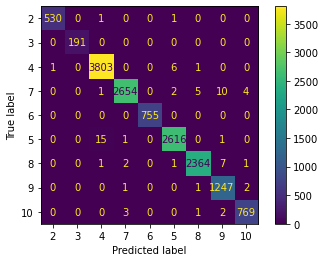

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_train, display_labels=classes)
disp.plot()
plt.show()

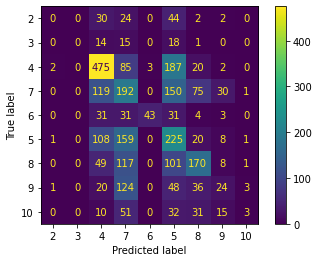

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_test, display_labels=classes)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train_pca, rf_final_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       532
           3       1.00      1.00      1.00       191
           4       1.00      1.00      1.00      3811
           5       1.00      0.99      0.99      2633
           6       1.00      1.00      1.00       755
           7       1.00      0.99      0.99      2676
           8       1.00      0.99      1.00      2376
           9       0.98      1.00      0.99      1251
          10       0.99      0.99      0.99       775

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [ ]:
print(classification_report(y_test_pca, rf_final_pred_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        48
           4       0.55      0.61      0.58       774
           5       0.27      0.43      0.33       522
           6       0.93      0.30      0.46       143
           7       0.24      0.34      0.28       567
           8       0.47      0.38      0.42       446
           9       0.26      0.09      0.14       256
          10       0.33      0.02      0.04       142

    accuracy                           0.38      3000
   macro avg       0.34      0.24      0.25      3000
weighted avg       0.39      0.38      0.36      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
x_train_pca = x_train_tf2[:15000]
y_train_pca = y_train[:15000]
x_test_pca = x_test_tf2[:3000]
y_test_pca = y_test[:3000]

print(x_train_pca.shape)
pca = PCA(n_components=100, random_state=0)

(15000, 11427)


In [ ]:
X_train_pca_new = pca.fit_transform(x_train_pca.toarray())
X_test_pca_new = pca.fit_transform(x_test_pca.toarray())

In [ ]:
print(pca.components_.shape)

(100, 11427)


In [ ]:
rf_final_pca = RandomForestClassifier(n_estimators=100, max_depth=None)

rf_final_pca = rf_final_pca.fit(X_train_pca_new, y_train_pca)
rf_final_pred = rf_final_pca.predict(X_train_pca_new)
rf_final_pred_test = rf_final_pca.predict(X_test_pca_new)

In [ ]:
test_acc_pca = accuracy_score(y_train_pca,rf_final_pred)
pca_score = f1_score(y_test_pca, rf_final_pred_test, average='micro')
print(f"Accuracy - {test_acc_pca}, f1-score - {pca_score}")

Accuracy - 0.9952666666666666, f1-score - 0.37533333333333335


In [ ]:
pca_con_train = confusion_matrix(y_train_pca, rf_final_pred, labels=classes)
pca_con_test = confusion_matrix(y_test_pca, rf_final_pred_test, labels=classes)

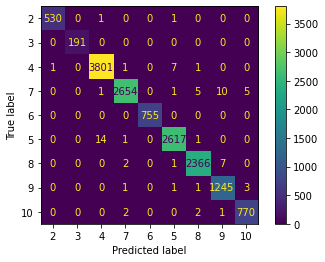

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_train, display_labels=classes)
disp.plot()
plt.show()

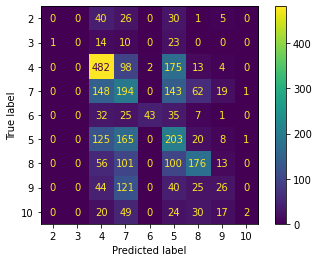

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_test, display_labels=classes)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train_pca, rf_final_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00       532
           3       1.00      1.00      1.00       191
           4       1.00      1.00      1.00      3811
           5       1.00      0.99      0.99      2633
           6       1.00      1.00      1.00       755
           7       1.00      0.99      0.99      2676
           8       1.00      1.00      1.00      2376
           9       0.99      1.00      0.99      1251
          10       0.99      0.99      0.99       775

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [ ]:
print(classification_report(y_test_pca, rf_final_pred_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00        48
           4       0.50      0.62      0.56       774
           5       0.26      0.39      0.31       522
           6       0.96      0.30      0.46       143
           7       0.25      0.34      0.29       567
           8       0.53      0.39      0.45       446
           9       0.28      0.10      0.15       256
          10       0.50      0.01      0.03       142

    accuracy                           0.38      3000
   macro avg       0.36      0.24      0.25      3000
weighted avg       0.39      0.38      0.35      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm = SVC(C=10, kernel='linear', verbose=1)
svm.fit(x_train_pca, y_train_pca)


pred_svm_train_pca = svm.predict(x_train_pca)
pred_svm_test_pca = svm.predict(x_test_pca)

[LibSVM]

In [ ]:
training_acc = accuracy_score(y_train_pca, pred_svm_train_pca)
test_acc = accuracy_score(y_test_pca, pred_svm_test_pca)

print('training accuracy: {}'.format(training_acc))
print('test accuracy: {}'.format(test_acc))


training accuracy: 0.9696
test accuracy: 0.612


In [ ]:
pca_con_train = confusion_matrix(y_train_pca, pred_svm_train_pca, labels=classes)
pca_con_test = confusion_matrix(y_test_pca, pred_svm_test_pca, labels=classes)

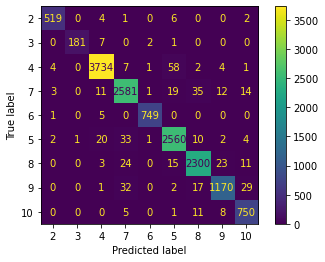

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_train, display_labels=classes)
disp.plot()
plt.show()

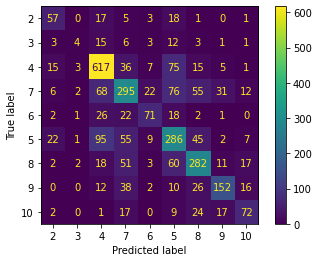

In [ ]:
disp = ConfusionMatrixDisplay(pca_con_test, display_labels=classes)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_train_pca, pred_svm_train_pca))

              precision    recall  f1-score   support

           2       0.98      0.98      0.98       532
           3       0.99      0.95      0.97       191
           4       0.99      0.98      0.98      3811
           5       0.96      0.97      0.97      2633
           6       0.99      0.99      0.99       755
           7       0.96      0.96      0.96      2676
           8       0.97      0.97      0.97      2376
           9       0.96      0.94      0.95      1251
          10       0.92      0.97      0.95       775

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



In [ ]:
print(classification_report(y_test_pca, pred_svm_test_pca))

              precision    recall  f1-score   support

           2       0.52      0.56      0.54       102
           3       0.31      0.08      0.13        48
           4       0.71      0.80      0.75       774
           5       0.51      0.55      0.53       522
           6       0.59      0.50      0.54       143
           7       0.56      0.52      0.54       567
           8       0.62      0.63      0.63       446
           9       0.69      0.59      0.64       256
          10       0.57      0.51      0.54       142

    accuracy                           0.61      3000
   macro avg       0.56      0.53      0.54      3000
weighted avg       0.61      0.61      0.61      3000

